### 测试

In [1]:
from instance_selection.e_mosaic.fitness import calculate_accuracy
from sklearn.preprocessing import StandardScaler
import numpy as np
from utils.dataset_utils import get_classes_indexes_counts
import scipy.io as sio  # 从.mat文件中读取数据集
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from instance_selection.e_mosaic.duplicate_process import find_duplicates, remove_duplicates
from instance_selection.e_mosaic.fitness import fitness_function
from instance_selection.e_mosaic.pop_init import init_by_one_or_zero, init_population_for_balanced_dataset, \
    init_population_for_balanced_dataset_2
from instance_selection.e_mosaic.genetic_operator import mutate_binary_inversion
import warnings
import array
import random
from deap import base
from deap import creator
from deap import tools
from instance_selection.e_mosaic.genetic_operator import selTournamentNDCD
from instance_selection.e_mosaic.ensemble_operator import vote_ensembles, calculate_gmean_mauc, \
    ensembles_individuals_gmean_mauc
from utils.dataset_utils import get_subset, k_fold_cross_validation
from sklearn.base import clone

warnings.filterwarnings("ignore")  # 忽略警告
# Nursery(20、100、0.1)、Satellite(15、100、0.1)、Contraceptive(15、200、0.1) Chess(20、200、0.1)
datasetname = 'Contraceptive.mat'
mat_data = sio.loadmat('../../data/dataset/' + datasetname)

dataset_x = mat_data['X']
dataset_y = mat_data['Y'][:, 0]  # mat_data['Y']得到的形状为[n,1]，通过[:,0]，得到形状[n,]


def main(model, random_seed, balanceset=False):
    ##############################################处理数据集#############################################################
    x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.3, random_state=random_seed)
    # 数据的标准化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    classes_train, counts_train = get_classes_indexes_counts(y_train)  # 统计每个类别的个数
    weights_train = (1 / counts_train.astype(float)) / np.sum(1 / counts_train.astype(float))  # 计算每个类的权重，用于计算每个类别的权重

    mlp = model
    n_splits = 5
    # 计算三个目标值初始值
    y_train_pred_proba = k_fold_cross_validation(model=mlp, X=x_train, y=y_train, n_splits=n_splits, method='soft',
                                                 random_state=random_seed)  # 交叉验证得到软标签
    # 将概率转化为预测结果
    y_train_pred = np.argmax(y_train_pred_proba, axis=1)

    Acc1, Acc2, Acc3 = calculate_accuracy(y_train_pred, y_train, weights_train)
    mlp_model = clone(mlp)
    mlp_model.fit(x_train, y_train)
    y_test_pred_proba = mlp_model.predict_proba(x_test)

    gmean_train, mauc_train, _ = calculate_gmean_mauc(y_train_pred_proba, y_train)

    gmean_test, mauc_test, _ = calculate_gmean_mauc(y_test_pred_proba, y_test)
    #############################################################################################################
    # 基本参数
    x_init_train = x_train  # 特征数据初始化
    y_init_train = y_train  # 标签初始化
    NDIM = len(y_init_train)  # 个体基因长度
    # 最大化评价目标
    creator.create("FitnessMaxAndMax", base.Fitness, weights=(1.0, 1.0))
    creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMaxAndMax, pfc=None, model=None,
                   y_sub_and_pred_proba=None, gmean=None, mauc=None)
    toolbox = base.Toolbox()
    toolbox.register("attr_binary", init_by_one_or_zero, binary=0)  # 0-1编码，基因全部初始化编码为0或1
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_binary, n=NDIM)  # 个体初始化
    toolbox.register("balanced_dataset_for_population_random", init_population_for_balanced_dataset,
                     y_train=y_init_train,
                     ratio=0.9, show_details=False)  # 初始化为平衡数据集（实例个数为min*0.9）
    toolbox.register("balanced_dataset_for_population_balanced", init_population_for_balanced_dataset_2,
                     y_train=y_init_train,
                     ratio=0.9, show_details=False)  # 初始化为平衡数据集（实例个数为min*0.9）
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # 种群初始化
    toolbox.register("evaluate", fitness_function)  # 评价函数
    toolbox.register("mate", tools.cxOnePoint)  # 交叉
    toolbox.register("mutate", mutate_binary_inversion)  # 二进制突变
    toolbox.register("select", tools.selNSGA2)  # NSGA-II选择（非支配排序后）
    toolbox.register("find_duplicates", find_duplicates)  # 找到种群中重复个体的索引对
    toolbox.register("remove_duplicates", remove_duplicates)  # 去重
    #########################################################迭代#####################################################

    NGEN = 30  # 迭代次数
    POPSIZE = 40  # 种群数量
    CXPB = 1.0  # 交叉因子/交叉率
    MR = 0.2  # 突变因子/突变率

    # 计算适应度，同时会保存训练好的mlp模型
    def get_fitness_values(individual):
        x_sub, y_sub = get_subset(individual, x_init_train, y_init_train)
        # 用实例选择的子集训练模型
        model_clone = clone(model)
        model_clone.fit(x_sub, y_sub)
        individual.model = model_clone
        y_pred_proba = k_fold_cross_validation(model=model, X=x_sub, y=y_sub, n_splits=n_splits, method='soft',
                                               random_state=random_seed)  # 交叉验证得到软标签
        individual.y_sub_and_pred_proba = (y_sub, y_pred_proba)  # 保存个体的软标签和预测概率
        individual.gmean, individual.mauc, _ = calculate_gmean_mauc(y_pred_proba, y_sub)  # 计算个体的gmean和mauc
        individual.fitness.values = toolbox.evaluate(individual)  # 计算个体的目标值

    ####################################迭代过程的记录#############################
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    logbook = tools.Logbook()
    logbook.header = "gen", "fronts", "ensembles_size", "avg_gmean", "avg_mauc"
    ####################################种群的初始化###########################
    pop = toolbox.population(n=POPSIZE)
    if balanceset:
        pop = toolbox.balanced_dataset_for_population_balanced(pop)  # 平衡种群中的个体
    else:
        pop = toolbox.balanced_dataset_for_population_random(pop)  # 随机平衡种群中的个体
    ####################################计算初始种群的适应度###########################
    ensembles = []  # 用于集成当前每个个体对应的mlp模型
    for i in range(len(pop)):
        get_fitness_values(pop[i])
    ####################################种群的迭代#################################################
    for gen in range(1, NGEN + 1):
        offspring = selTournamentNDCD(pop, POPSIZE, tournsize=3)  # 锦标赛选择（1、先根据非支配排序的等级2、再根据拥挤距离）
        offspring = [toolbox.clone(ind) for ind in offspring]
        for i in range(0, len(offspring) - 1, 2):
            if random.random() <= CXPB:
                offspring[i], offspring[i + 1] = toolbox.mate(offspring[i], offspring[i + 1])  # 单点交叉
            offspring[i] = toolbox.mutate(offspring[i], MR)[0]  # 二进制反转突变
            offspring[i + 1] = toolbox.mutate(offspring[i + 1], MR)[0]  # 二进制反转突变
            del offspring[i].fitness.values, offspring[i + 1].fitness.values
        #############################################################合并、去重#####################################################
        pop = pop + offspring  # 种群的合并
        duplicates = toolbox.find_duplicates(pop)
        pop, num_duplicates = toolbox.remove_duplicates(pop, duplicates)  # 去重
        while len(pop) < POPSIZE:
            add_individual = []
            num_add = POPSIZE - len(pop)
            for i in range(0, num_add):
                index = random.randint(0, len(offspring) - 1)  # 在0-len(offspring)范围内随机产生一个索引
                offspring[index] = toolbox.mutate(offspring[index], MR)[0]  # 选择index对应的个体进行突变
                del offspring[index].fitness.values
                add_individual.append(offspring[index])
            pop = pop + add_individual  # 种群的合并
            add_duplicates = toolbox.find_duplicates(pop)  # 找到重复个体的索引对
            pop, _ = toolbox.remove_duplicates(pop, add_duplicates)  # 去重
        # 计算新种群适应度
        for i in range(len(pop)):
            if not pop[i].fitness.valid:
                get_fitness_values(pop[i])
        ###############################################得到pareto_fronts############################################
        pop = toolbox.select(pop, POPSIZE)
        pareto_fronts = tools.sortNondominated(pop, len(pop))

        ensembles_individuals = pareto_fronts[0]
        avg_gmean, avg_mauc = ensembles_individuals_gmean_mauc(ensembles_individuals)
        record = stats.compile(pop)
        avg_gmean, avg_mauc = ensembles_individuals_gmean_mauc(ensembles_individuals)
        logbook.record(gen=gen, fronts=len(pareto_fronts), ensembles_size=len(ensembles_individuals),
                       avg_gmean=avg_gmean, avg_mauc=avg_mauc, **record)
        print(logbook.stream)
    # 对最后的结果进行集成
    ensembles.clear()
    for ind in ensembles_individuals:
        ensembles.append(ind.model)
    return stats, ensembles, ensembles_individuals, x_test, y_test, Acc1, Acc2, Acc3, gmean_train, mauc_train, gmean_test, mauc_test


if __name__ == "__main__":
    # MLP
    learning_rate = 0.1  # 学习率
    hidden_size = 15  # 隐含层神经元数量
    max_iter = 200  # 最大迭代次数（epoch）
    # run
    run_num = 10

    # 记录的值
    acc_random = [[] for _ in range(run_num)]
    geam_mauc_random = [[] for _ in range(run_num)]
    ensembles_result_random = [[] for _ in range(run_num)]
    acc_balanced = [[] for _ in range(run_num)]
    geam_mauc_balanced = [[] for _ in range(run_num)]
    ensembles_result_balanced = [[] for _ in range(run_num)]

    print("###############################随机#######################################")
    for i in range(run_num):
        print(f"第{i + 1}次执行")
        random_seed = i + 42
        mlp = MLPClassifier(hidden_layer_sizes=(hidden_size,), max_iter=max_iter, random_state=random_seed,
                            learning_rate_init=learning_rate)
        stats, ensembles, ensembles_individuals, x_test, y_test, Acc1, Acc2, Acc3, gmean_train, mauc_train, gmean_test, mauc_test = main(
            random_seed=random_seed, model=mlp, balanceset=False)
        acc_random[i] = [Acc1, Acc2, Acc3]
        geam_mauc_random[i] = [gmean_train, mauc_train, gmean_test, mauc_test]
        g_mean, m_auc, recall_per_class, Acc2 = vote_ensembles(ensembles, x_test, y_test, show_result=False)
        ensembles_result_random[i] = [g_mean, m_auc, Acc2]
        print(f"最终的集成分类结果：Recall_Per_Class{recall_per_class}，Gmean：{g_mean}，mAUC：{m_auc}")
    print("训练已结束！")
    print("###############################平衡#######################################")
    for i in range(run_num):
        print(f"第{i + 1}次执行")
        random_seed = i + 42
        mlp = MLPClassifier(hidden_layer_sizes=(hidden_size,), max_iter=max_iter, random_state=random_seed,
                            learning_rate_init=learning_rate)
        stats, ensembles, ensembles_individuals, x_test, y_test, Acc1, Acc2, Acc3, gmean_train, mauc_train, gmean_test, mauc_test = main(
            random_seed=random_seed, model=mlp, balanceset=True)
        acc_balanced[i] = [Acc1, Acc2, Acc3]
        geam_mauc_balanced[i] = [gmean_train, mauc_train, gmean_test, mauc_test]
        g_mean, m_auc, recall_per_class, Acc2 = vote_ensembles(ensembles, x_test, y_test, show_result=False)
        ensembles_result_balanced[i] = [g_mean, m_auc, Acc2]
        print(f"最终的集成分类结果：Recall_Per_Class{recall_per_class}，Gmean：{g_mean}，mAUC：{m_auc}")
    print("训练已结束！")

    # 对acc、geam_mauc、ensembles_result求平均值
    acc_mean_random = np.mean(acc_random, axis=0)
    geam_mauc_mean_random = np.mean(geam_mauc_random, axis=0)
    ensembles_result_mean_random = np.mean(ensembles_result_random, axis=0)
    # 对acc、geam_mauc、ensembles_result求平均值
    acc_mean_balanced = np.mean(acc_balanced, axis=0)
    geam_mauc_mean_balanced = np.mean(geam_mauc_balanced, axis=0)
    ensembles_result_mean_balanced = np.mean(ensembles_result_balanced, axis=0)

###############################随机#######################################
第1次执行
gen	fronts	ensembles_size	avg_gmean	avg_mauc
1  	11    	1             	0.5569   	0.7085  
2  	13    	1             	0.5648   	0.7175  
3  	11    	2             	0.572    	0.7166  
4  	8     	3             	0.5598   	0.7175  
5  	8     	3             	0.5598   	0.7175  
6  	8     	4             	0.5601   	0.7177  
7  	9     	4             	0.5601   	0.7177  
8  	10    	5             	0.5572   	0.7194  
9  	8     	4             	0.5666   	0.7238  
10 	8     	4             	0.5666   	0.7238  
11 	8     	4             	0.5666   	0.7238  
12 	7     	4             	0.5666   	0.7238  
13 	8     	3             	0.5733   	0.7386  
14 	9     	2             	0.5898   	0.7421  
15 	9     	2             	0.5898   	0.7421  
16 	9     	2             	0.5898   	0.7421  
17 	10    	3             	0.5843   	0.7449  
18 	8     	3             	0.5843   	0.7449  
19 	9     	3             	0.5843   	0.7449  
20 	8     	4         

### 绘制ensemble_gmean_mauc_acc2折线图

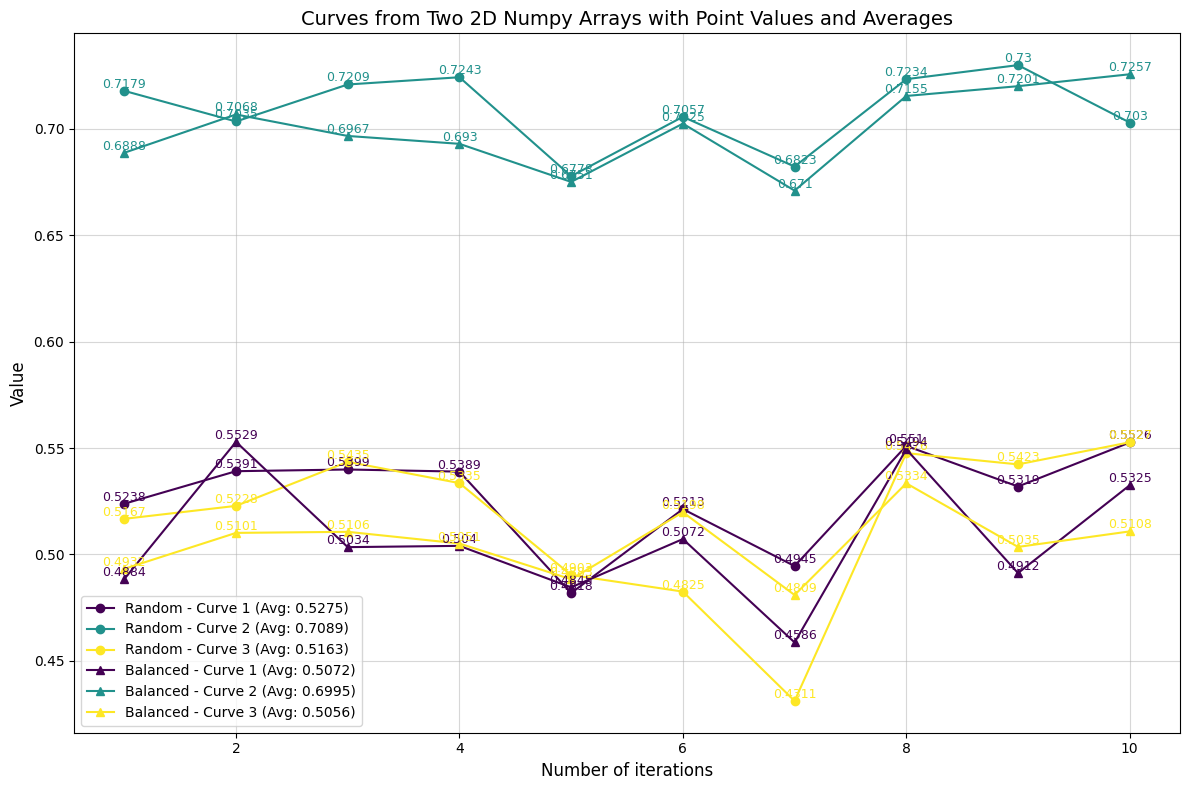

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Example data
data1 = np.array(ensembles_result_random).T
data2 = np.array(ensembles_result_balanced).T

# Define markers and colors
markers = ['o', '^']  # 'o' for data1, '^' for data2
datasets = [data1, data2]
colors1 = plt.cm.viridis(np.linspace(0, 1, len(data1)))
colors2 = plt.cm.viridis(np.linspace(0, 1, len(data2)))

plt.figure(figsize=(12, 8))

# Plot Dataset 1
for i, (curve, color) in enumerate(zip(data1, colors1)):
    x = np.arange(1, len(curve) + 1)
    y = curve
    avg = np.mean(y)
    plt.plot(x, y, marker=markers[0], label=f'Random - Curve {i + 1} (Avg: {avg:.4f})', color=color)
    for xi, yi in zip(x, y):
        plt.text(xi, yi, f'{yi}', fontsize=9, ha='center', va='bottom', color=color)

# Plot Dataset 2
for i, (curve, color) in enumerate(zip(data2, colors2)):
    x = np.arange(1, len(curve) + 1)
    y = curve
    avg = np.mean(y)
    plt.plot(x, y, marker=markers[1], label=f'Balanced - Curve {i + 1} (Avg: {avg:.4f})', color=color)
    for xi, yi in zip(x, y):
        plt.text(xi, yi, f'{yi}', fontsize=9, ha='center', va='bottom', color=color)

# Plot settings
plt.title('Curves from Two 2D Numpy Arrays with Point Values and Averages', fontsize=14)
plt.xlabel('Number of iterations', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()

save_path = 'C:\\Users\\zsc\\Desktop\\evolution computation\\meeting\\2024.12.31\\e-mosaic\\' + datasetname.split('.')[0] + '\\'
# 创建文件夹（如果不存在）
folder = os.path.dirname(save_path)
if not os.path.exists(folder):
    os.makedirs(folder)
# Show plot
plt.savefig(save_path + datasetname.split('.')[0] + f'ensemble_gmean_mauc_acc2.jpg', dpi=300, bbox_inches='tight')


### 绘制init_gmean_mauc折线图折线图

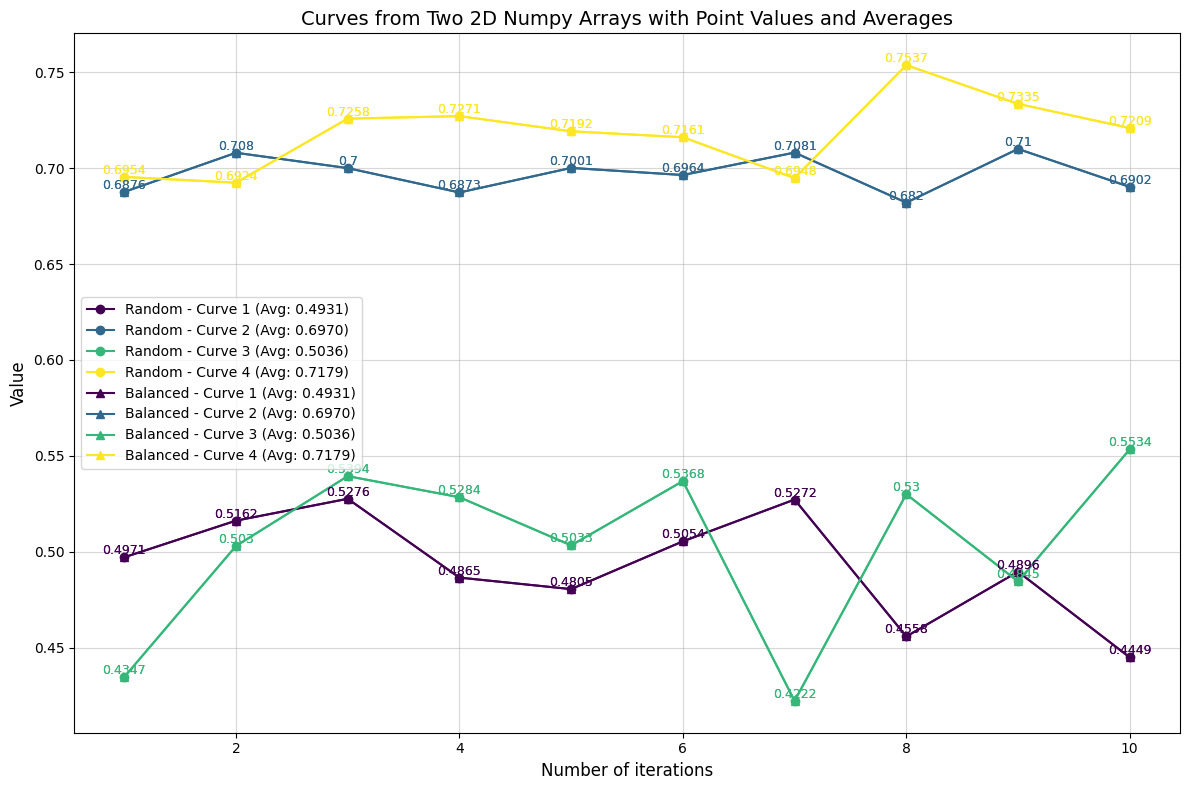

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Example data
data1 = np.array(geam_mauc_random).T
data2 = np.array(geam_mauc_balanced).T

# Define markers and colors
markers = ['o', '^']  # 'o' for data1, '^' for data2
datasets = [data1, data2]
colors1 = plt.cm.viridis(np.linspace(0, 1, len(data1)))
colors2 = plt.cm.viridis(np.linspace(0, 1, len(data2)))

plt.figure(figsize=(12, 8))

# Plot Dataset 1
for i, (curve, color) in enumerate(zip(data1, colors1)):
    x = np.arange(1, len(curve) + 1)
    y = curve
    avg = np.mean(y)
    plt.plot(x, y, marker=markers[0], label=f'Random - Curve {i + 1} (Avg: {avg:.4f})', color=color)
    for xi, yi in zip(x, y):
        plt.text(xi, yi, f'{yi}', fontsize=9, ha='center', va='bottom', color=color)

# Plot Dataset 2
for i, (curve, color) in enumerate(zip(data2, colors2)):
    x = np.arange(1, len(curve) + 1)
    y = curve
    avg = np.mean(y)
    plt.plot(x, y, marker=markers[1], label=f'Balanced - Curve {i + 1} (Avg: {avg:.4f})', color=color)
    for xi, yi in zip(x, y):
        plt.text(xi, yi, f'{yi}', fontsize=9, ha='center', va='bottom', color=color)

# Plot settings
plt.title('Curves from Two 2D Numpy Arrays with Point Values and Averages', fontsize=14)
plt.xlabel('Number of iterations', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()

save_path = 'C:\\Users\\zsc\\Desktop\\evolution computation\\meeting\\2024.12.31\\e-mosaic\\' + datasetname.split('.')[0] + '\\'
# 创建文件夹（如果不存在）
folder = os.path.dirname(save_path)
if not os.path.exists(folder):
    os.makedirs(folder)
# Show plot
plt.savefig(save_path + datasetname.split('.')[0] + f'init_gmean_mauc.jpg', dpi=300, bbox_inches='tight')


### 绘制init_acc折线图

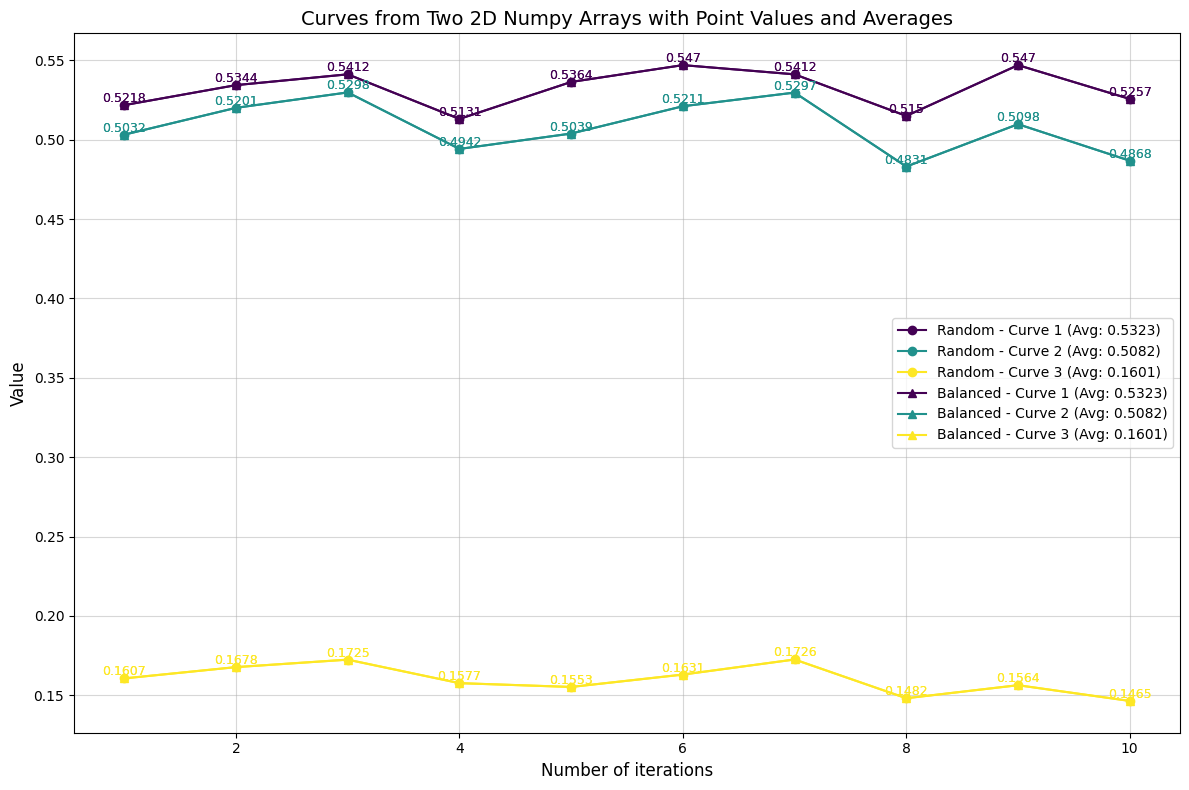

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Example data
data1 = np.array(acc_random).T
data2 = np.array(acc_balanced).T

# Define markers and colors
markers = ['o', '^']  # 'o' for data1, '^' for data2
datasets = [data1, data2]
colors1 = plt.cm.viridis(np.linspace(0, 1, len(data1)))
colors2 = plt.cm.viridis(np.linspace(0, 1, len(data2)))

plt.figure(figsize=(12, 8))

# Plot Dataset 1
for i, (curve, color) in enumerate(zip(data1, colors1)):
    x = np.arange(1, len(curve) + 1)
    y = curve
    avg = np.mean(y)
    plt.plot(x, y, marker=markers[0], label=f'Random - Curve {i + 1} (Avg: {avg:.4f})', color=color)
    for xi, yi in zip(x, y):
        plt.text(xi, yi, f'{yi}', fontsize=9, ha='center', va='bottom', color=color)

# Plot Dataset 2
for i, (curve, color) in enumerate(zip(data2, colors2)):
    x = np.arange(1, len(curve) + 1)
    y = curve
    avg = np.mean(y)
    plt.plot(x, y, marker=markers[1], label=f'Balanced - Curve {i + 1} (Avg: {avg:.4f})', color=color)
    for xi, yi in zip(x, y):
        plt.text(xi, yi, f'{yi}', fontsize=9, ha='center', va='bottom', color=color)

# Plot settings
plt.title('Curves from Two 2D Numpy Arrays with Point Values and Averages', fontsize=14)
plt.xlabel('Number of iterations', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()

save_path = 'C:\\Users\\zsc\\Desktop\\evolution computation\\meeting\\2024.12.31\\e-mosaic\\' + datasetname.split('.')[0] + '\\'
# 创建文件夹（如果不存在）
folder = os.path.dirname(save_path)
if not os.path.exists(folder):
    os.makedirs(folder)
# Show plot
plt.savefig(save_path + datasetname.split('.')[0] + f'init_acc.jpg', dpi=300, bbox_inches='tight')


### 绘制Acc折线图

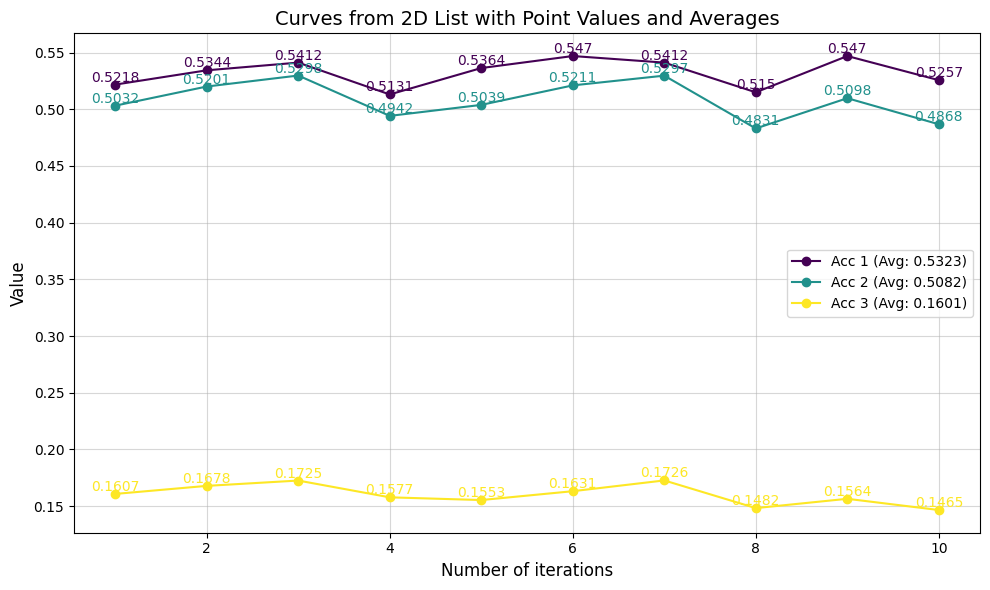

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data
data = np.array(acc_balanced).T
num_curves = len(data)
colors = plt.cm.viridis(np.linspace(0, 1, num_curves))

# Plot
plt.figure(figsize=(10, 6))
for i, (curve, color) in enumerate(zip(data, colors)):
    x = list(range(1, len(curve) + 1))  # X-axis: Index of values
    y = curve  # Y-axis: Values
    avg = np.mean(y)  # Average of the curve

    # Plot curve with points
    plt.plot(x, y, marker='o', label=f'Acc {i + 1} (Avg: {avg:.4f})', color=color)

    # Annotate each point
    for xi, yi in zip(x, y):
        plt.text(xi, yi, f'{yi}', fontsize=10, ha='center', va='bottom', color=color)

# Plot settings
plt.title('Curves from 2D List with Point Values and Averages', fontsize=14)
plt.xlabel('Number of iterations', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.tight_layout()

save_path = 'C:\\Users\\zsc\\Desktop\\evolution computation\\meeting\\2024.12.31\\'
# Show plot
plt.savefig(save_path + datasetname + f'acc.jpg', dpi=300, bbox_inches='tight')
